In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import itertools

Using TensorFlow backend.


In [2]:
# Load the data
train = pd.read_csv("./train.csv")

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
Y_train = train["label"]
X_train = train.drop(labels=["label"], axis=1) 

del train

## Check missing values

In [5]:
DATA = X_train
for var in DATA.columns:
    if DATA[var].isnull().sum():
        print(var, 'sum:', DATA[var].isnull().sum(), ", mean: %.3f" %DATA[var].isnull().mean())

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, 
                                                    random_state=42)

In [7]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [8]:
epochs = 1 
batch_size = 64

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

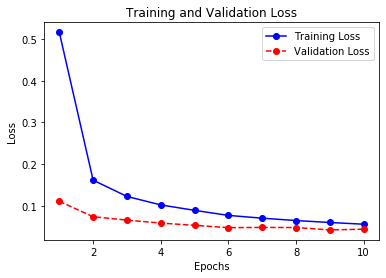

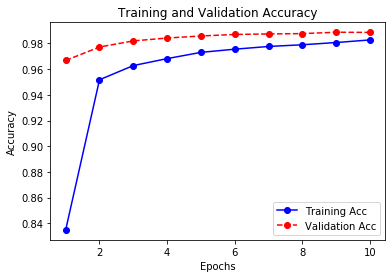

In [9]:
seed = 42
np.random.seed(seed)
# convert to 4D tensor
X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1).astype("float32")
X_test = X_test.values.reshape(X_test.shape[0], 28, 28, 1).astype("float32")

# normallization
X_train = X_train/255.
X_test = X_test/255.

# One-hot encoding
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

# input fig shape = 28*28*1
model = Sequential()
model.add(Conv2D(filters=16, # ouput channel number 
                 kernel_size=(5, 5), # filter or kernel shape = 5*5
                 padding="same", # output the same shape by padding 0, i.e., (28 - 5 + 2*2)/1 + 1 = 28
                 input_shape=(28, 28, 1), # height * weight * channel_num 
                 activation="relu")) # 0 or x 
model.add(MaxPooling2D(pool_size=(2, 2))) # 2*2 -> *1/2, 3*3 -> *1/3, due to the formula!
# output shape = 14*14*16

model.add(Conv2D(32, kernel_size=(5, 5), padding="same",
                 activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5)) # regularization
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

history = model.fit(X_train, Y_train, validation_split=0.2,
                    epochs=10, batch_size=128, verbose=0)

print("Testing ...")
loss, accuracy = model.evaluate(X_train, Y_train)
print("Train accuracy = {:.2f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test accuracy = {:.2f}".format(accuracy))

print("Saving Model: model.h5 ...")
model.save("model.h5")

# train and validation losses
loss = history.history["loss"]
epochs = range(1, len(loss)+1)
val_loss = history.history["val_loss"]
plt.plot(epochs, loss, "bo-", label="Training Loss")
plt.plot(epochs, val_loss, "ro--", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# train and validation accuracies
acc = history.history["accuracy"]
epochs = range(1, len(acc)+1)
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo-", label="Training Acc")
plt.plot(epochs, val_acc, "ro--", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [11]:
def plot_confusion_matrix(cfm, classes, normalize=False, title='Confusion matrix', 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cfm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]

    thresh = cfm.max()/2.
    for i, j in itertools.product(range(cfm.shape[0]), range(cfm.shape[1])):
        plt.text(j, i, cfm[i, j], horizontalalignment="center",
                 color="white" if cfm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

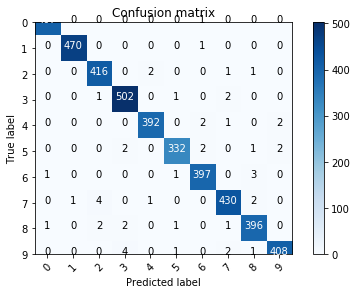

In [12]:
Y_pred = model.predict(X_test)
# convert to one hot vectors 
Y_pred = np.argmax(Y_pred, axis=1) 

Y_true = np.argmax(Y_test, axis=1) 

cfm = confusion_matrix(Y_true, Y_pred) 
plot_confusion_matrix(cfm, classes=range(10)) 

In [13]:
test = pd.read_csv("./test.csv")
test = test/255.0
test = test.values.reshape(-1, 28, 28, 1)

In [14]:
results = model.predict(test)
# select the indix with the maximum probability
results = np.argmax(results, axis=1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1, 28001),name="ImageId"), results], axis=1)
submission.to_csv("/Users/paulin/Desktop/cnn_mnist.csv", index=False)